<a href="https://colab.research.google.com/github/aliaksei135/sandbox/blob/master/UAS%20Path%20GA/UAS_Path_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deps

In [1]:
!pip install numpy matplotlib scikit_image
import numpy as np
import matplotlib.pyplot as mpl
%matplotlib notebook
import random
from functools import partial
from skimage.draw import line
from typing import Tuple

# Setup GA classes


In [2]:
class Path:
    """
    A representation of a path.

    The path is encoded as a N by 2 array encoding [x, y] coordinates each path node of path length N
    """

    def __init__(self) -> None:
        super().__init__()
        self.path = []
        self.enc_path = None  # enc_path is always the most up to date version, path can be lagging
        self.f = np.inf

    def encode_path(self):
        path_len = len(self.path)
        enc_path = np.zeros((path_len, 2), dtype=int)
        for idx, coord in enumerate(self.path):
            enc_path[idx, :] = np.array(coord, dtype=int)
        self.enc_path = enc_path

    def decode_path(self):
        self.path = []
        for coord in self.enc_path:
            self.path.append((int(coord[0]), int(coord[1])))

    def get_path(self):
        self.decode_path()
        return self.path

In [3]:
class GeneticAlgorithm:

    def __init__(self, fitness_funcs, fitness_weights=None) -> None:
        super().__init__()

        self.population = []

        self.grid = None

        # lists of functions to call for fitness
        # all func should take a single Path arg
        # fitness func should return float of fitness value or 0 if constraints not met
        self.fitness = fitness_funcs
        if not fitness_weights:
            self.fitness_weights = np.ones(len(fitness_funcs))
        else:
            if len(fitness_weights) == len(fitness_funcs):
                self.fitness_weights = fitness_weights
            else:
                raise ValueError("The number of fitness weights must match the number of fitness funcs")

    def find_path(self, grid: np.array, start: Tuple[int,int], goal: Tuple[int,int], **kwargs):
        self.grid = grid
        self.start = start
        self.end = goal

        path = self.run(**kwargs)

        return [c for c in path.enc_path]

    def initialise(self, population_size, path_length):

        ymax, xmax = self.grid.shape

        for _ in range(population_size):
            indiv = Path()
            indiv.path.append(self.start)
            for _ in range(path_length - 2):
                x = int(np.random.randint(0, xmax))
                y = int(np.random.randint(0, ymax))
                indiv.path.append((y, x))
            indiv.path.append(self.end)
            indiv.encode_path()
            self.population.append(indiv)

    def _eval_fitness(self, path):
        n_fitness = len(self.fitness)
        vfit = np.zeros(n_fitness)
        for i in range(n_fitness):
            vfit[i] = self.fitness[i](path)
        return (vfit * self.fitness_weights).sum()

    def select(self, selection_type='tournament'):
        selection = []
        selection_append = selection.append
        if selection_type == 'tournament':
            for _ in range(2 * len(self.population)):
                par1, par2 = random.sample(self.population, 2)
                sfit1 = self._eval_fitness(par1)
                sfit2 = self._eval_fitness(par2)
                if sfit1 > sfit2:
                    selection_append(par1)
                else:
                    selection_append(par2)
            return list(zip(selection[0::2], selection[1::2]))
        elif selection_type == 'roulette':
            pass
        else:  # elitist
            pass

    def crossover(self, candidates):
        """
        Single point crossover of parents
        :param candidates:
        :return:
        """
        xver = []
        for par1, par2 in candidates:
            n = min(par1.enc_path.shape[0], par2.enc_path.shape[0])
            x_point = np.random.randint(0, n - 1)
            child = Path()
            child.enc_path = np.vstack((par1.enc_path[0:x_point], par2.enc_path[x_point:]))
            xver.append(child)
        return xver

    def mutate(self, candidates, mutation_prob=0.2, mutation_type='cull'):
        """
        Mutate nodes in the path
        :param candidates: the genes to mutate
        :param mutation_prob: probability of mutation. Applied differently depending on `mutation_type`
        :param mutation_type: the type of mutation to carry out
        :return:
        """
        mutants = []
        for cand in candidates:
            n = cand.enc_path.shape[0]
            mutant = Path()
            if mutation_type == 'cull':
                cull_mask = np.random.random(n) > mutation_prob
                cull_mask[0] = cull_mask[-1] = True  # do not cull start or end points
                mutant.enc_path = cand.enc_path[cull_mask]
                mutants.append(mutant)
            elif mutation_type == 'monotone':
                # if np.random.random() < mutation_prob or n < 4:
                ix1 = np.random.randint((n // 2) - 1) + 1
                ix2 = np.random.randint((n // 2) + 1, n - 2)
                x0, y0 = cand.enc_path[ix1]
                x1, y1 = cand.enc_path[ix2]
                l = line(x0, y0, x1, y1)
                coords = np.vstack((l[0], l[1])).T.astype(int)
                coords_mask = np.random.random(coords.shape[0]) > mutation_prob
                coords = coords[coords_mask]
                mutant.enc_path = np.vstack((cand.enc_path[0:ix1], coords, cand.enc_path[ix2:]))
                mutants.append(mutant)
                # else:
                #     mutants.append(cand)
        return mutants

    def run(self, generations=500, population_size=400, stagnant_generations_end=40, init_path_length=100, ):
        self.initialise(population_size, init_path_length)
        best_fit_path = Path()
        stagnant_gens = 0

        for gen in range(generations):
            print('Run generation ', gen)
            selection = self.select()
            xver = self.crossover(selection)
            mut = self.mutate(xver, mutation_type='cull')

            gen_fitness = {self._eval_fitness(p): p for p in mut}
            gen_best_fit = min(gen_fitness.keys())
            if gen_best_fit < best_fit_path.f:
                print('New Best Fitness:', gen_best_fit, '| Fitness Improvement ', best_fit_path.f - gen_best_fit)
                best_fit_path = gen_fitness[gen_best_fit]
                best_fit_path.f = gen_best_fit
                stagnant_gens = 0

            else:
                stagnant_gens += 1
                if stagnant_gens > stagnant_generations_end:
                    return best_fit_path
            self.population = mut
        return best_fit_path

# Fitness Functions


In [4]:
def fitness_min_euclidean_length(max_val, path):
    dist = 0
    for n0, n1 in zip(path.enc_path, path.enc_path[1:]):
        dist += ((n0[0] - n1[1]) ** 2 + (n0[1] - n1[1]) ** 2) ** 0.5
    return dist / max_val


def fitness_min_manhattan_length(max_val, path):
    dist = 0
    for n0, n1 in zip(path.enc_path, path.enc_path[1:]):
        dist += abs(n0[0] - n1[1]) + abs(n0[1] - n1[1])
    return dist / max_val


def fitness_min_nodes(path):
    return len(path.get_path())


def fitness_min_energy(path):
    return 0


def fitness_correct_endpoints(start, end, path):
    if (path.enc_path[0] == start).all() and (path.enc_path[-1] == end).all():
        return 0
    return np.inf


def fitness_min_risk(grid, grid_max, path):
    # This also handles obstacle collisions as they are encoded as np.inf in the grid,
    # therefore summing with them gives np.inf as well
    risk = 0
    enc = path.enc_path
    for idx, n0 in enumerate(enc[:-1]):
        n1 = enc[idx + 1]
        l = line(n0[0], n0[1], n1[0], n1[1])
        risk += grid[l[0], l[1]].sum()

    return risk / grid_max

# Demo Data Ingest

In [5]:
large_test_grid = np.genfromtxt('costmap.csv', delimiter=',')

# Run

Run generation  0
New Best Fitness: 3.058642885762448e+18 | Fitness Improvement  inf
Run generation  1
New Best Fitness: 2.6077257139559526e+18 | Fitness Improvement  4.509171718064952e+17
Run generation  2
New Best Fitness: 2.0216612942597932e+18 | Fitness Improvement  5.860644196961595e+17
Run generation  3
New Best Fitness: 1.6706976190570936e+18 | Fitness Improvement  3.509636752026995e+17
Run generation  4
New Best Fitness: 1.2499050105022367e+18 | Fitness Improvement  4.2079260855485696e+17
Run generation  5
New Best Fitness: 6.965504027321321e+17 | Fitness Improvement  5.533546077701046e+17
Run generation  6
Run generation  7
Run generation  8
New Best Fitness: 3.6794083775214906e+17 | Fitness Improvement  3.2860956497998304e+17
Run generation  9
New Best Fitness: 3.378504648789232e+17 | Fitness Improvement  3.0090372873225856e+16
Run generation  10
New Best Fitness: 2.7792990684073686e+17 | Fitness Improvement  5.992055803818634e+16
Run generation  11
Run generation  12
New Bes

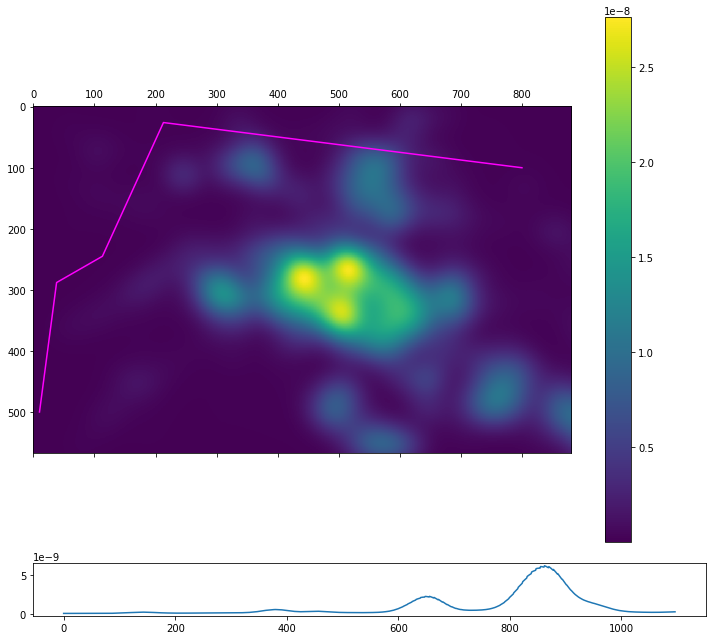

In [7]:
# y, x order!
start = (500, 10)
end = (100, 800)
grid = large_test_grid
grid_max = grid.max()

# Normalise distances by the max diagonal distance
max_dist = np.sqrt((grid.shape[0] ** 2) + (grid.shape[1] ** 2))

# Fitness funcs are expected to only take a path, so partial in the other args
fitness_funcs = [
    partial(fitness_min_risk, grid, grid_max),
    partial(fitness_min_manhattan_length, max_dist)
]

# Weight fitness funcs in corresponding order. These get summed to single value by GA
fitness_weights = [
    1e15, # Most of the risk map value is ~ 1e-8
    1
]

algo = GeneticAlgorithm(fitness_funcs, fitness_weights)
path = algo.find_path(grid, start, end)


fig, (ax1, ax2) = mpl.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(10,9))
g = ax1.matshow(grid)
fig.colorbar(g, ax=ax1)
ax1.plot([n[1] for n in path], [n[0] for n in path], color='magenta')
ys = []
for idx in range(len(path[:-1])):
    n0 = path[idx]
    n1 = path[idx + 1]
    l = line(n0[0], n0[1], n1[0], n1[1])
    ys.append(grid[l[0], l[1]])
ys = np.hstack(ys)
ax2.plot(ys)

mpl.tight_layout()
fig.show()